In [ ]:
# default_exp jupyterlabel

In [ ]:
# hide
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# export
import csv
import sys

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# export
class Labeler:
    def __init__(self, df, target_var, output_path=None, features=None):
        self.df = df
        self.features = features
        self.target_var = target_var
        self.output_path = output_path
        
    def _validate_input(self):
        while True:
            label = input('Enter option: ')
            if label == 'save' or label in self._labels:
                break
            else:
                continue
        return label
    
    def _clear_output(self):
        clear_output(wait=True)
    
    def _display(self):
        display(self._row[self.features])
    
    def __call__(self):
        while self._count <= self._n:
            self._clear_output()
            print(f"Valid options: {', '.join(self._labels)}, save")
            print(f"Total samples labeled: {self._count}/{self._n}")
            self._row = self._df.sample(1, replace=False)
            self._display()
            self._label = self._validate_input()
            if self._label == 'save':
                break
            self._row['manual_label'] = self._label
            self._label_df = self._label_df.append(self._row.copy())
            self._count += 1
    
    def __enter__(self):
        self._labels = self.df[self.target_var].unique()
        self._mapping = {}
        self._n = len(self.df)
        self._count = 0
        self._df = self.df[self.features + [self.target_var]].copy() if self.features else self.df.copy()
        self._label_df = pd.DataFrame(columns=list(self._df.columns) + ['manual_label'])
        for ix, label in enumerate(self._labels):
            self._mapping[ix] = label
        return self
    
    def _plot_cm(self, cm):
        fig = plt.figure()
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues)
        ax.set_xlabel('Predicted labels');
        ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(self._labels); 
        ax.yaxis.set_ticklabels(self._labels);
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self._count > 0:
            self._label_df['manual_label'].replace(self._mapping, inplace=True)
            cm = confusion_matrix(self._label_df[self.target_var],
                                  self._label_df['manual_label'],
                                  labels=self._labels)
            self._plot_cm(cm)

            if self.output_path:
                print(f"Writing csv to {self.output_path}")
                self._label_df.to_csv(self.output_path)

Valid options: Yes, No, save
Total samples labeled: 14/128


,Goal Scored,Ball Possession %,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes
62,0,45,2,3,4,7,1,11,0,79,424


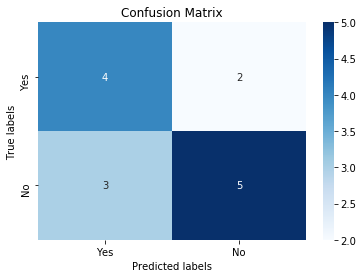

In [ ]:
import random

input_file = '../data/FIFA 2018 Statistics.csv'
df = pd.read_csv(input_file)
target_var = 'Man of the Match'

features = [
    'Goal Scored', 'Ball Possession %',
    'On-Target', 'Off-Target',
    'Blocked',
    'Corners',
    'Offsides', 
    'Free Kicks', 
    'Saves',
    'Pass Accuracy %',
    'Passes'
]

def monkey_patch_validate_input():
    rand = random.random()
    if rand < 0.9:
        return random.choice(['Yes', 'No'])
    return 'save'

labeler = Labeler(df, target_var, features=features)
labeler._validate_input = monkey_patch_validate_input

with labeler as l:
    assert list(l._labels) == ["Yes", "No"]
    assert l._mapping == {0:"Yes", 1:"No"}
    assert l._n == 128
    assert l._count == 0
    l()
    assert len(l._row) == 1